## Importing the libraries

In [3]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, concatenate, MaxPool2D, Flatten, Dense, Input, AveragePooling2D, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
import time
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
from sklearn.model_selection import train_test_split

# Ignore Warnings
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Data preprocessing
### Getting the images

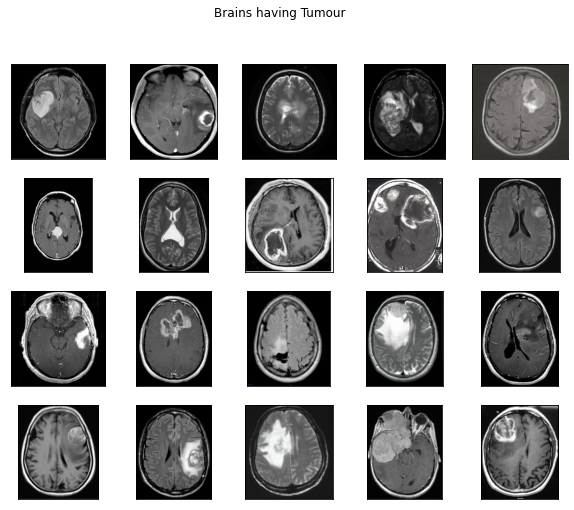

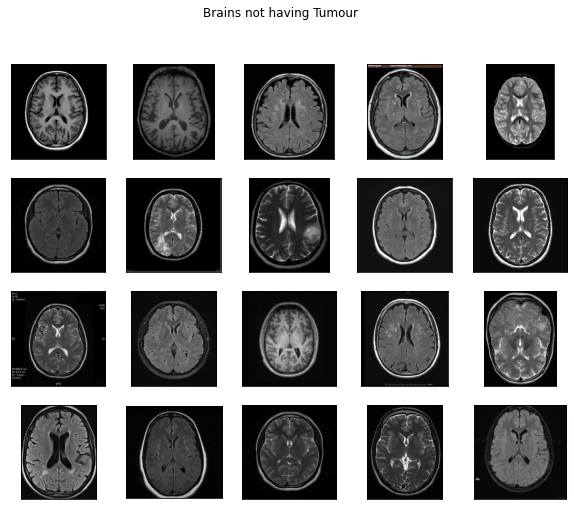

In [26]:
y_img = []
n_img = []
for img in glob.glob("brain_tumor_dataset/yes/*"):
    n = cv2.imread(img)
    y_img.append(n)
for img in glob.glob('brain_tumor_dataset/no/*'):
    n = cv2.imread(img)
    n_img.append(n)

# Printing retrieved images

plt.figure(num=1, figsize=(10, 8))
for i in range(20):
    plt.subplot(4, 5, i+1), plt.imshow(y_img[i])
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Brains having Tumour')
plt.figure(num=2, figsize=(10, 8))
for i in range(20):
    plt.subplot(4, 5, i+1), plt.imshow(n_img[i])
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Brains not having Tumour')

### Cropping input images

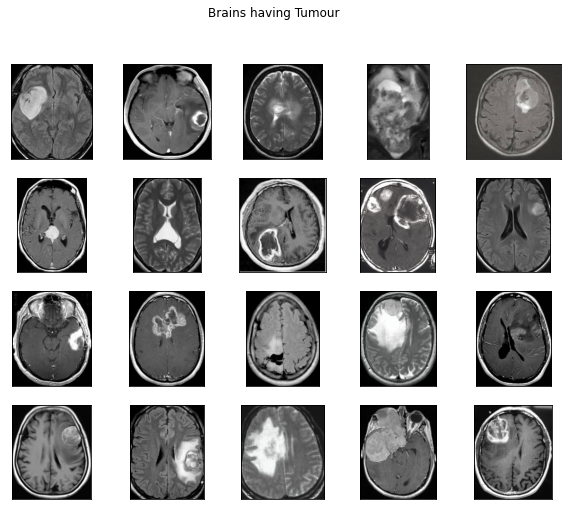

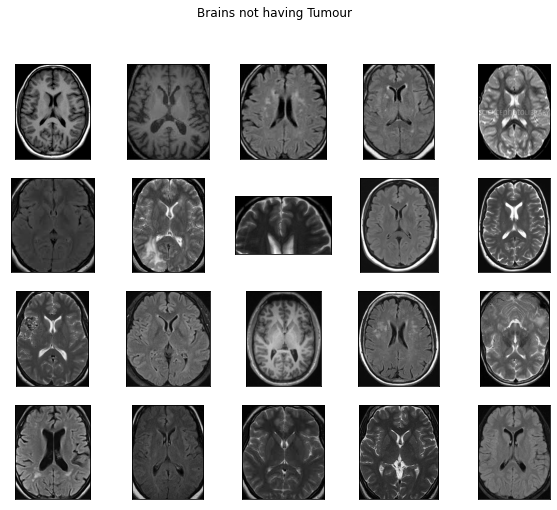

In [57]:
cropped_images_n = []
cropped_images_y = []
for i in y_img:
    img = i.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, None, iterations=2)
    conts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(conts)
    c = max(conts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    cropped_images_y.append(img[extTop[1]:extBot[1], extLeft[0]:extRight[0]])

for i in n_img:
    img = i.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, None, iterations=2)
    conts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(conts)
    c = max(conts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    cropped_images_n.append(img[extTop[1]:extBot[1], extLeft[0]:extRight[0]])

# Printing cropped images

plt.figure(num=3, figsize=(10, 8))
for i in range(20):
    plt.subplot(4, 5, i+1), plt.imshow(cropped_images_y[i])
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Brains having Tumour')
plt.figure(num=4, figsize=(10, 8))
for i in range(20):
    plt.subplot(4, 5, i+1), plt.imshow(cropped_images_n[i])
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Brains not having Tumour')

### Splitting dataset

In [61]:
Yes_train, Yes_test, _, _ = train_test_split(cropped_images_y, cropped_images_y, test_size=1/3, random_state=1)
No_train, No_test, _, _ = train_test_split(cropped_images_n, cropped_images_n, test_size=1/4, random_state=1)

print("No. of images in Yes train", len(Yes_train))
print("No. of images in Yes test", len(Yes_test))
print("No. of images in No train", len(No_train))
print("No. of images in No test", len(No_test))

No. of images in Yes train 103
No. of images in Yes test 52
No. of images in No train 73
No. of images in No test 25


### Saving in proper directory structure

In [62]:
def save_it(set, folder_name):
    for i in range(len(set)):
        cv2.imwrite(folder_name+str(i+1)+'.jpg', set[i])

save_it(Yes_train, 'Processed_dataset/training/Yes/')
save_it(No_train, 'Processed_dataset/training/No/')
save_it(Yes_test, 'Processed_dataset/test/Yes/')
save_it(No_test, 'Processed_dataset/test/No/')

## Main Model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 224, 224, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 74, 74, 32)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 74, 74, 64)   2112        max_pooling2d_3[0][0]            
____________________________________________________________________________________________

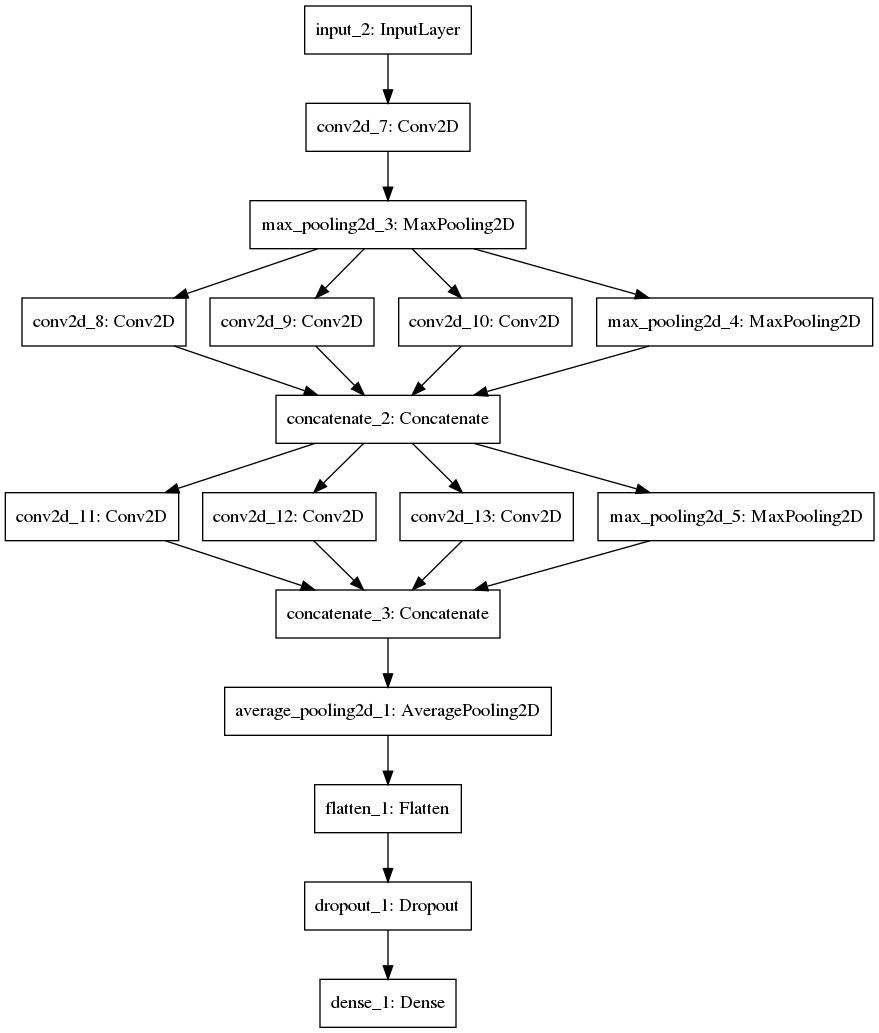

In [4]:
def InceptionBlock(prev_layer, n1, n2, n3):
    conv1 = Conv2D(n1, (1, 1), padding='same', activation='relu')(prev_layer)
    conv3 = Conv2D(n2, (3, 3), padding='same', activation='relu')(prev_layer)
    conv5 = Conv2D(n3, (5, 5), padding='same', activation='relu')(prev_layer)
    pool = MaxPool2D((3, 3), strides=(1, 1), padding='same')(prev_layer)
    output = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return output
input_layer = Input(shape=(224, 224, 3))
layer1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
layer2 = MaxPool2D(pool_size=(3, 3))(layer1)
layer3 = InceptionBlock(layer2, 64, 128, 32)
layer4 = InceptionBlock(layer3, 128, 192, 96)
layer5 = AveragePooling2D((3, 3))(layer4)
layer6 = Flatten()(layer5)
layer7 = Dropout(0.2)(layer6)
layer8 = Dense(units=1, activation='sigmoid')(layer7)
model = Model(inputs=input_layer, outputs=layer8)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()
plot_model(model, show_shapes=False, to_file='First-Model.png')

## Fitting model to dataset

In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
        'Processed_dataset/training',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

validation_generator=test_datagen.flow_from_directory(
        'Processed_dataset/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

tensorboard = TensorBoard(log_dir = "logs/{}".format(time.time()))
tensorboard.set_model(model)
history = model.fit_generator(
        train_generator,
        steps_per_epoch=176,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=77,
        callbacks=[tensorboard])

model.save('First_Model.h5')

Found 176 images belonging to 2 classes.
Found 77 images belonging to 2 classes.
Epoch 1/20
175/176 [============================>.] - ETA: 7s - loss: 0.3246 - acc: 0.8608WARNING:tensorflow:From /home/suyash/.local/lib/python3.6/site-packages/keras/callbacks/tensorboard_v1.py:343: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.

176/176 [==============================] - 1484s 8s/step - loss: 0.3235 - acc: 0.8615 - val_loss: 0.4670 - val_acc: 0.8446
Epoch 2/20
176/176 [==============================] - 1488s 8s/step - loss: 0.1447 - acc: 0.9505 - val_loss: 0.5043 - val_acc: 0.8441
Epoch 3/20
176/176 [==============================] - 1487s 8s/step - loss: 0.0566 - acc: 0.9827 - val_loss: 0.6324 - val_acc: 0.8703
Epoch 4/20
176/176 [==============================] - 1484s 8s/step - loss: 0.0330 - acc: 0.9913 - val_loss: 0.8358 - val_acc: 0.8441
Epoch 5/20
176/176 [==============================] - 1492s 8s/step - loss: 0.0124 - acc: 0.9979 - val_loss: 0.9777 

## Plotting Results

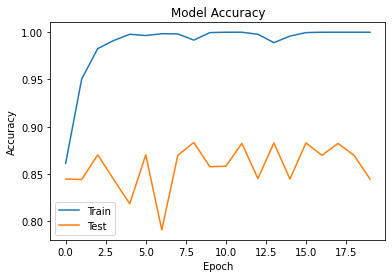

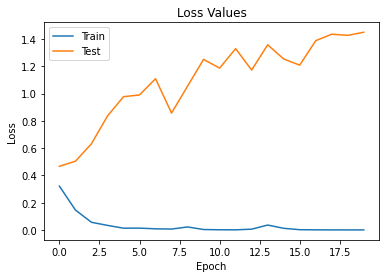

In [16]:
#Plotting Accuracy v/s Epochs
plt.figure(5)
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
#Plotting Loss v/s Epochs
plt.figure(6)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Values')

plt.show()